# １．VAEの重みを可視化するプログラム

In [ ]:
# インポートをここのセルにまとめる
import yaml
import os
import shutil
from pathlib import Path
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import sys

from src.models import CAE

In [ ]:
# 設定ファイルとチェックポイントパスを指定
root_restult_dir = Path('/workspace/result')
ex_name = 'grayscale_autoencoder_v2_MSELoss_100'
config_path = root_restult_dir / ex_name / 'config.yaml'
checkpoint_path = root_restult_dir / ex_name / 'ckpts/cae_best.pth'

# 設定ファイルを読み込み
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# モデルを初期化
model = CAE(config)

# チェックポイントを読み込み
if Path(checkpoint_path).exists():
    model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
    print(f"✓ Loaded checkpoint from: {checkpoint_path}")
else:
    print(f"✗ Checkpoint not found: {checkpoint_path}")

model.eval()
print(f"✓ Model loaded successfully")


✓ Loaded checkpoint from: /workspace/result/grayscale_autoencoder_v2_MSELoss_100/ckpts/cae_best.pth
✓ Model loaded successfully



ENCODER LAYERS

Encoder Layer 1
  Config: 1 -> 32 channels
          kernel_size=3, padding=1
  Weight shape: (32, 1, 3, 3)


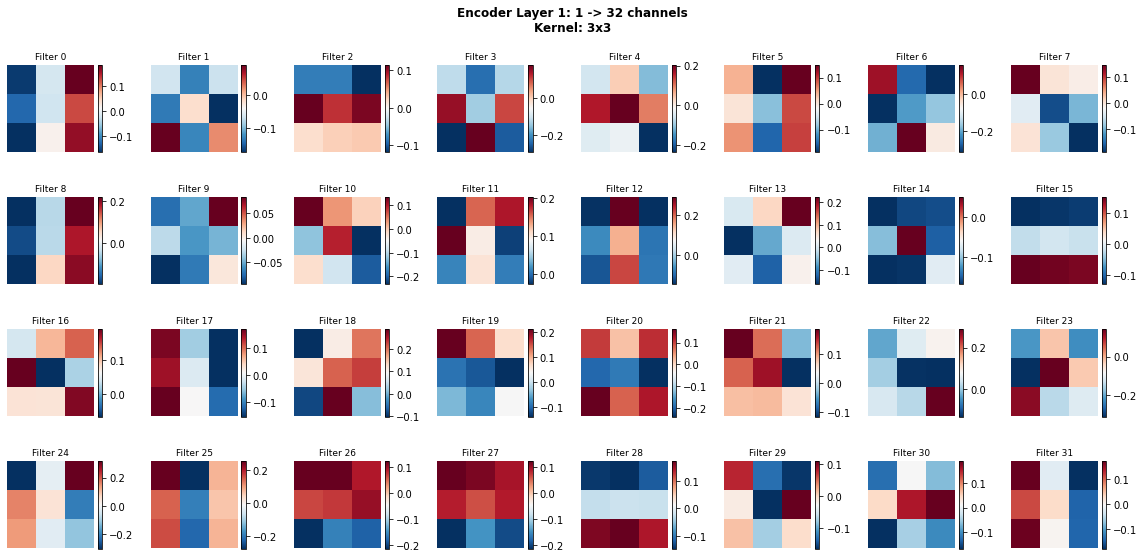


Encoder Layer 2
  Config: 32 -> 64 channels
          kernel_size=3, padding=1
  Weight shape: (64, 32, 3, 3)


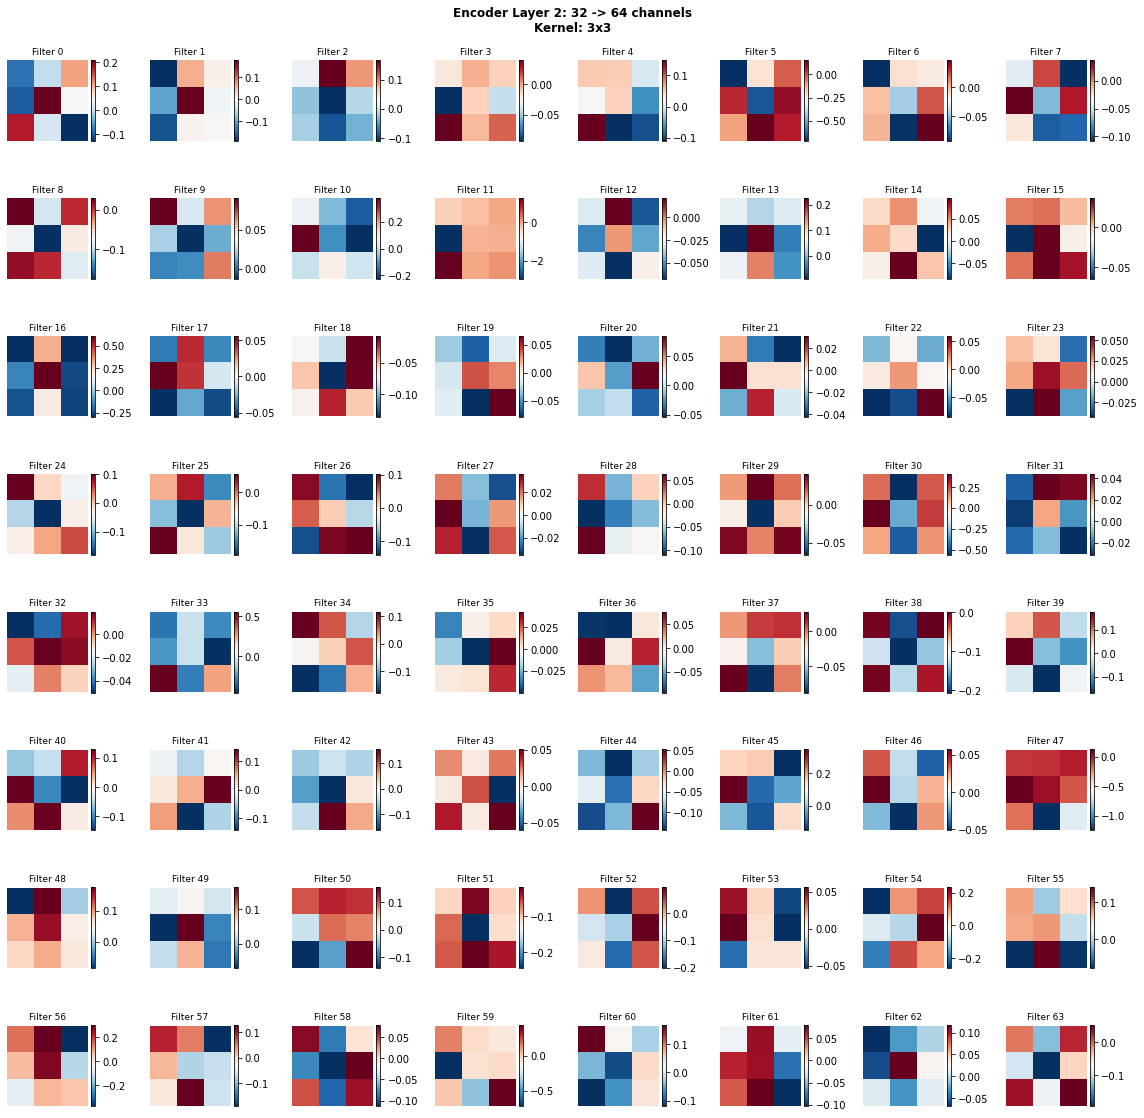


Encoder Layer 3
  Config: 64 -> 128 channels
          kernel_size=3, padding=1
  Weight shape: (128, 64, 3, 3)


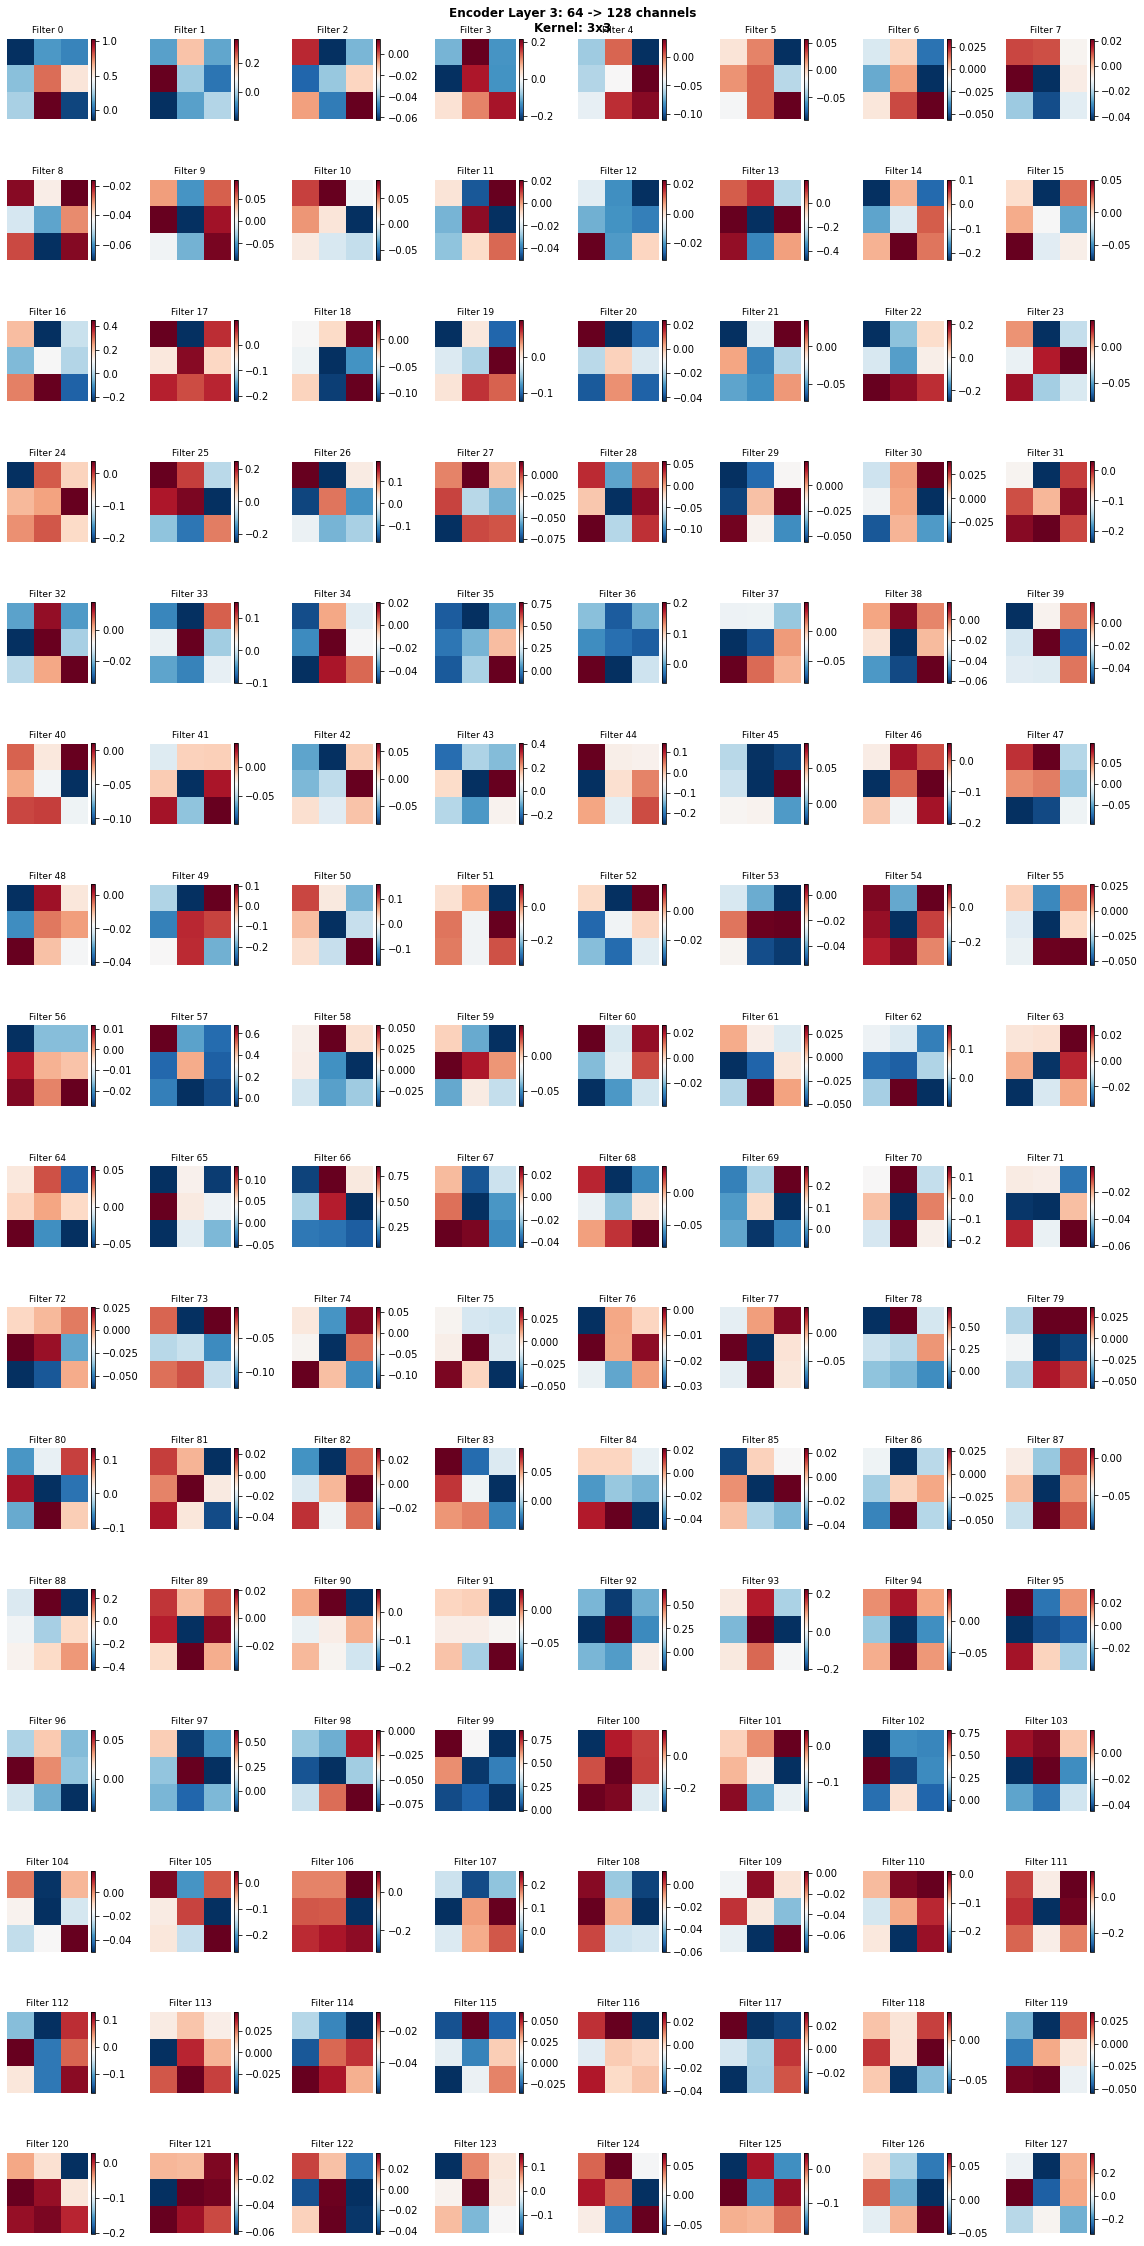

In [5]:
# Encoder層の重みを別々に表示
print("\n" + "="*80)
print("ENCODER LAYERS")
print("="*80)

encoder_layers = config['model']['encoder_layers']
conv_count = 0

for name, module in model.encoder.named_modules():
    if isinstance(module, nn.Conv2d):
        weights = module.weight.data.cpu().numpy()  # shape: (out_ch, in_ch, h, w)
        out_ch, in_ch, h, w = weights.shape
        
        layer_info = encoder_layers[conv_count]
        
        print(f"\nEncoder Layer {conv_count + 1}")
        print(f"  Config: {layer_info['in_channels']} -> {layer_info['out_channels']} channels")
        print(f"          kernel_size={layer_info['kernel_size']}, padding={layer_info['padding']}")
        print(f"  Weight shape: {weights.shape}")
        
        # 最初の入力チャンネルのフィルタのみを表示
        num_filters = out_ch
        cols = min(8, num_filters)
        rows = (num_filters + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
        fig.suptitle(f'Encoder Layer {conv_count + 1}: {in_ch} -> {out_ch} channels\nKernel: {h}x{w}',
                     fontsize=12, fontweight='bold')
        
        if rows == 1 and cols == 1:
            axes = np.array([[axes]])
        elif rows == 1 or cols == 1:
            axes = axes.reshape(rows, cols)
        
        for i in range(num_filters):
            row, col = i // cols, i % cols
            ax = axes[row, col]
            
            # 最初の入力チャンネルのフィルタを表示
            filter_img = weights[i, 0, :, :]
            im = ax.imshow(filter_img, cmap='RdBu_r')
            ax.set_title(f'Filter {i}', fontsize=9)
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # 余った領域を削除
        for i in range(num_filters, rows * cols):
            row, col = i // cols, i % cols
            fig.delaxes(axes[row, col])
        
        plt.tight_layout()
        plt.show()
        
        conv_count += 1



DECODER LAYERS

Decoder Layer 1
  Config: 128 -> 64 channels
          kernel_size=3, padding=1
  Weight shape: (64, 128, 3, 3)


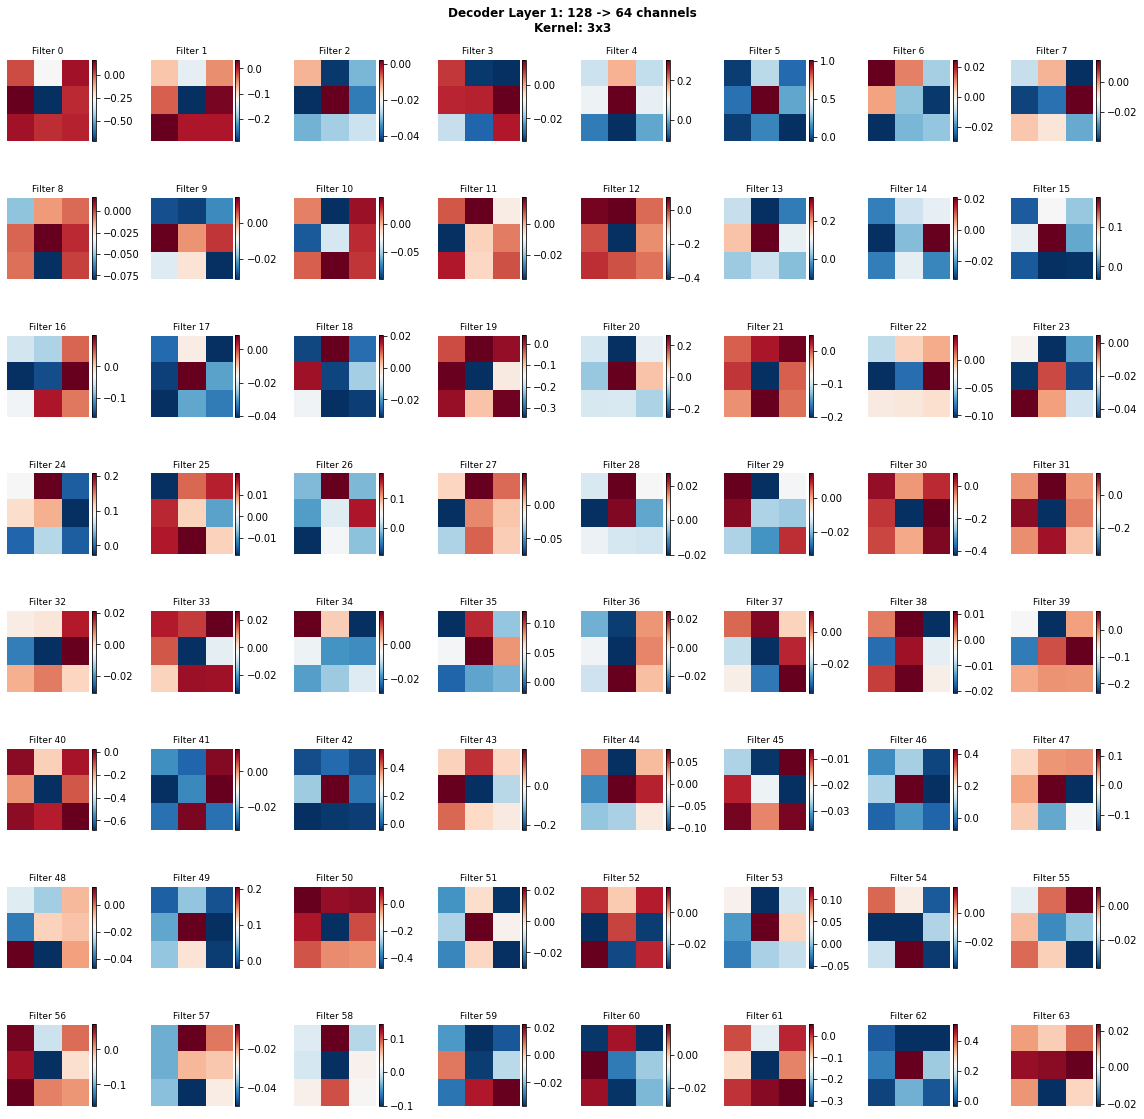


Decoder Layer 2
  Config: 64 -> 32 channels
          kernel_size=3, padding=1
  Weight shape: (32, 64, 3, 3)


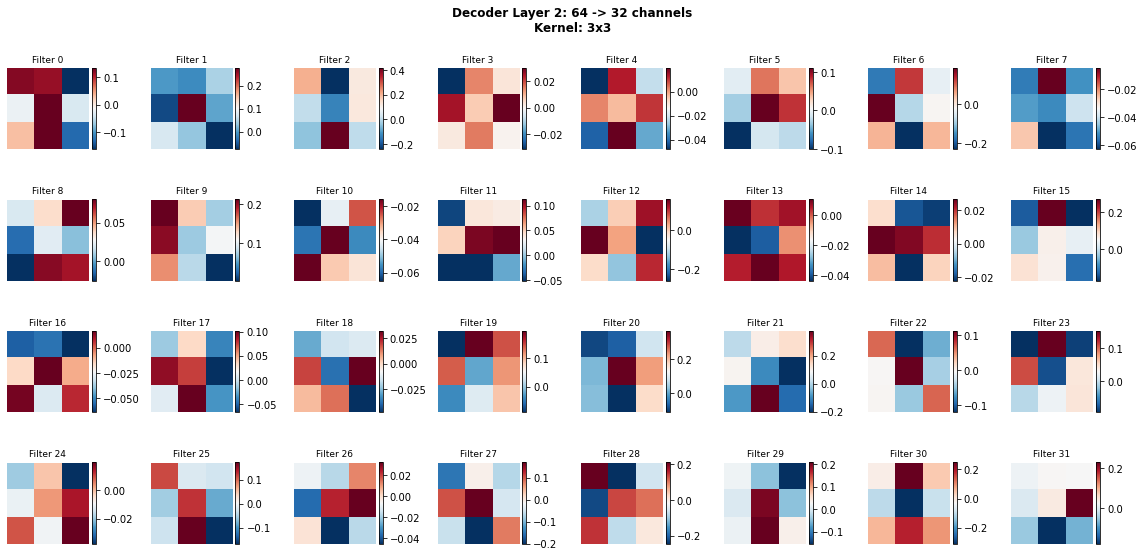


Decoder Layer 3
  Config: 32 -> 32 channels
          kernel_size=3, padding=1
  Weight shape: (32, 32, 3, 3)


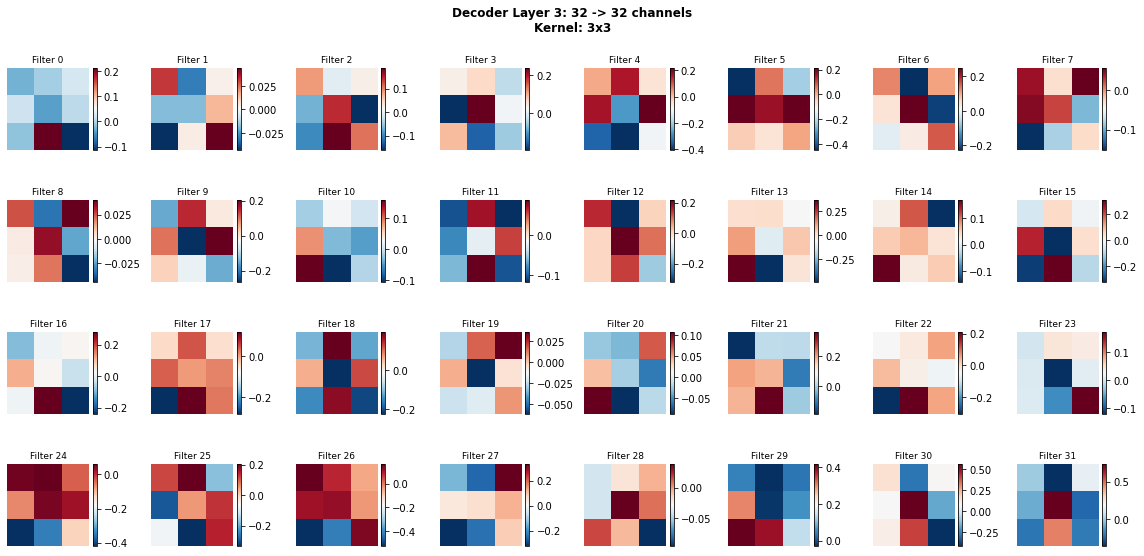


Decoder Layer 4
  Config: 32 -> 1 channels
          kernel_size=3, padding=1
  Weight shape: (1, 32, 3, 3)


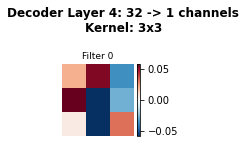

In [6]:
# Decoder層の重みを別々に表示
print("\n" + "="*80)
print("DECODER LAYERS")
print("="*80)

decoder_layers = config['model']['decoder_layers']
final_layer = config['model']['final_layer']
all_decoder_layers = decoder_layers + [final_layer]

conv_count = 0

for name, module in model.decoder.named_modules():
    if isinstance(module, nn.Conv2d):
        weights = module.weight.data.cpu().numpy()  # shape: (out_ch, in_ch, h, w)
        out_ch, in_ch, h, w = weights.shape
        
        if conv_count < len(all_decoder_layers):
            layer_info = all_decoder_layers[conv_count]
            
            print(f"\nDecoder Layer {conv_count + 1}")
            print(f"  Config: {layer_info['in_channels']} -> {layer_info['out_channels']} channels")
            print(f"          kernel_size={layer_info['kernel_size']}, padding={layer_info['padding']}")
            print(f"  Weight shape: {weights.shape}")
            
            # 最初の入力チャンネルのフィルタのみを表示
            num_filters = out_ch
            cols = min(8, num_filters)
            rows = (num_filters + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
            fig.suptitle(f'Decoder Layer {conv_count + 1}: {in_ch} -> {out_ch} channels\nKernel: {h}x{w}',
                         fontsize=12, fontweight='bold')
            
            if rows == 1 and cols == 1:
                axes = np.array([[axes]])
            elif rows == 1 or cols == 1:
                axes = axes.reshape(rows, cols)
            
            for i in range(num_filters):
                row, col = i // cols, i % cols
                ax = axes[row, col]
                
                # 最初の入力チャンネルのフィルタを表示
                filter_img = weights[i, 0, :, :]
                im = ax.imshow(filter_img, cmap='RdBu_r')
                ax.set_title(f'Filter {i}', fontsize=9)
                ax.axis('off')
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
            # 余った領域を削除
            for i in range(num_filters, rows * cols):
                row, col = i // cols, i % cols
                fig.delaxes(axes[row, col])
            
            plt.tight_layout()
            plt.show()
        
        conv_count += 1
